All libraries imported successfully
Data Loaded:
   Training: (888, 16), Test: (222, 16)
   Features: 16
Base models loaded: ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge', 'neural_network']
Ensemble Models Created:
   BAGGING NEURAL NETWORK
   BAGGING RANDOM FOREST
   BOOSTING GRADIENT BOOST
   STACKING NEURAL RIDGE NEURAL FINAL
   STACKING NEURAL RIDGE RIDGE FINAL
   STACKING NEURAL ONLY

NOTE: Bagging applied to Neural Network with 10 estimators
NOTE: Stacking with Neural Network final estimator
NOTE: Stacking with Ridge final estimator
NOTE: Neural-only stacking configuration

TRAINING ENSEMBLE MODELS WITH 10-FOLD CROSS-VALIDATION

[MODEL] Training BAGGING_NEURAL_NETWORK with 10-fold CV...
   BAGGING NEURAL NETWORK Trained
      10-Fold CV RMSE: 3.3228
      Test RMSE: 3.1765
      Test R²: -0.3461

[MODEL] Training BAGGING_RANDOM_FOREST with 10-fold CV...
   BAGGING RANDOM FOREST Trained
      10-Fold CV RMSE: 2.2325
      Test RMSE: 2.5007
      Test R²: 0.1658

[MODEL]

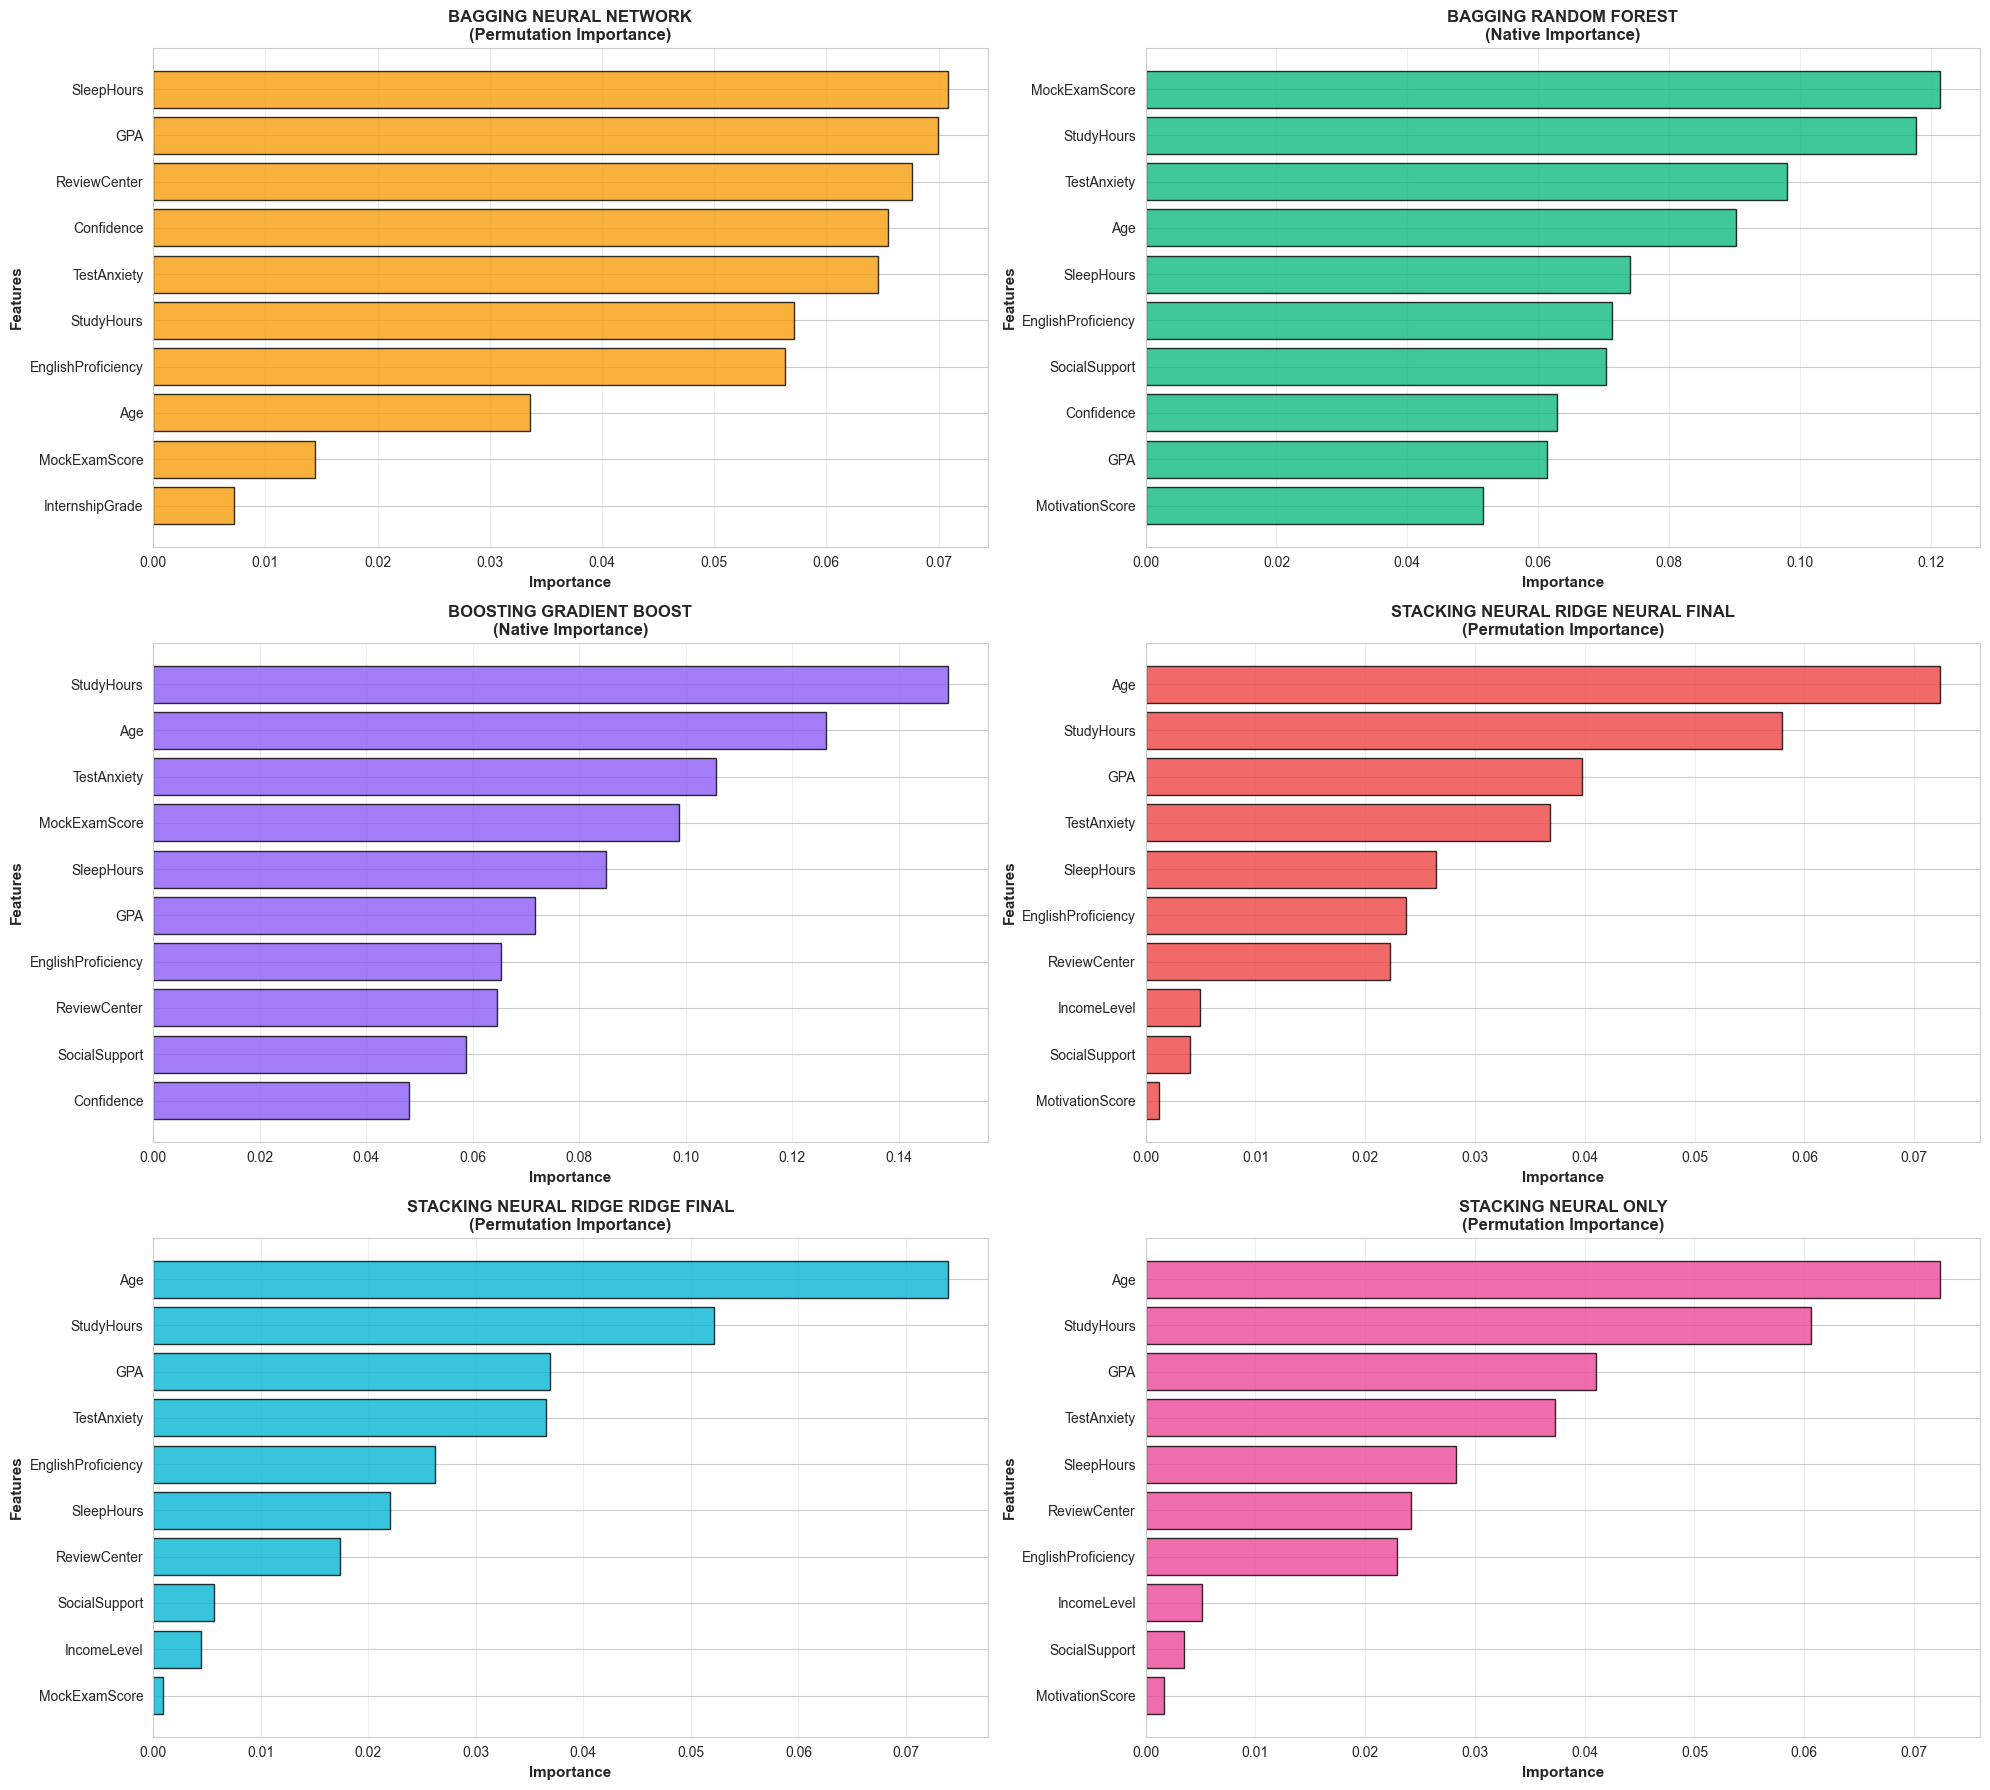

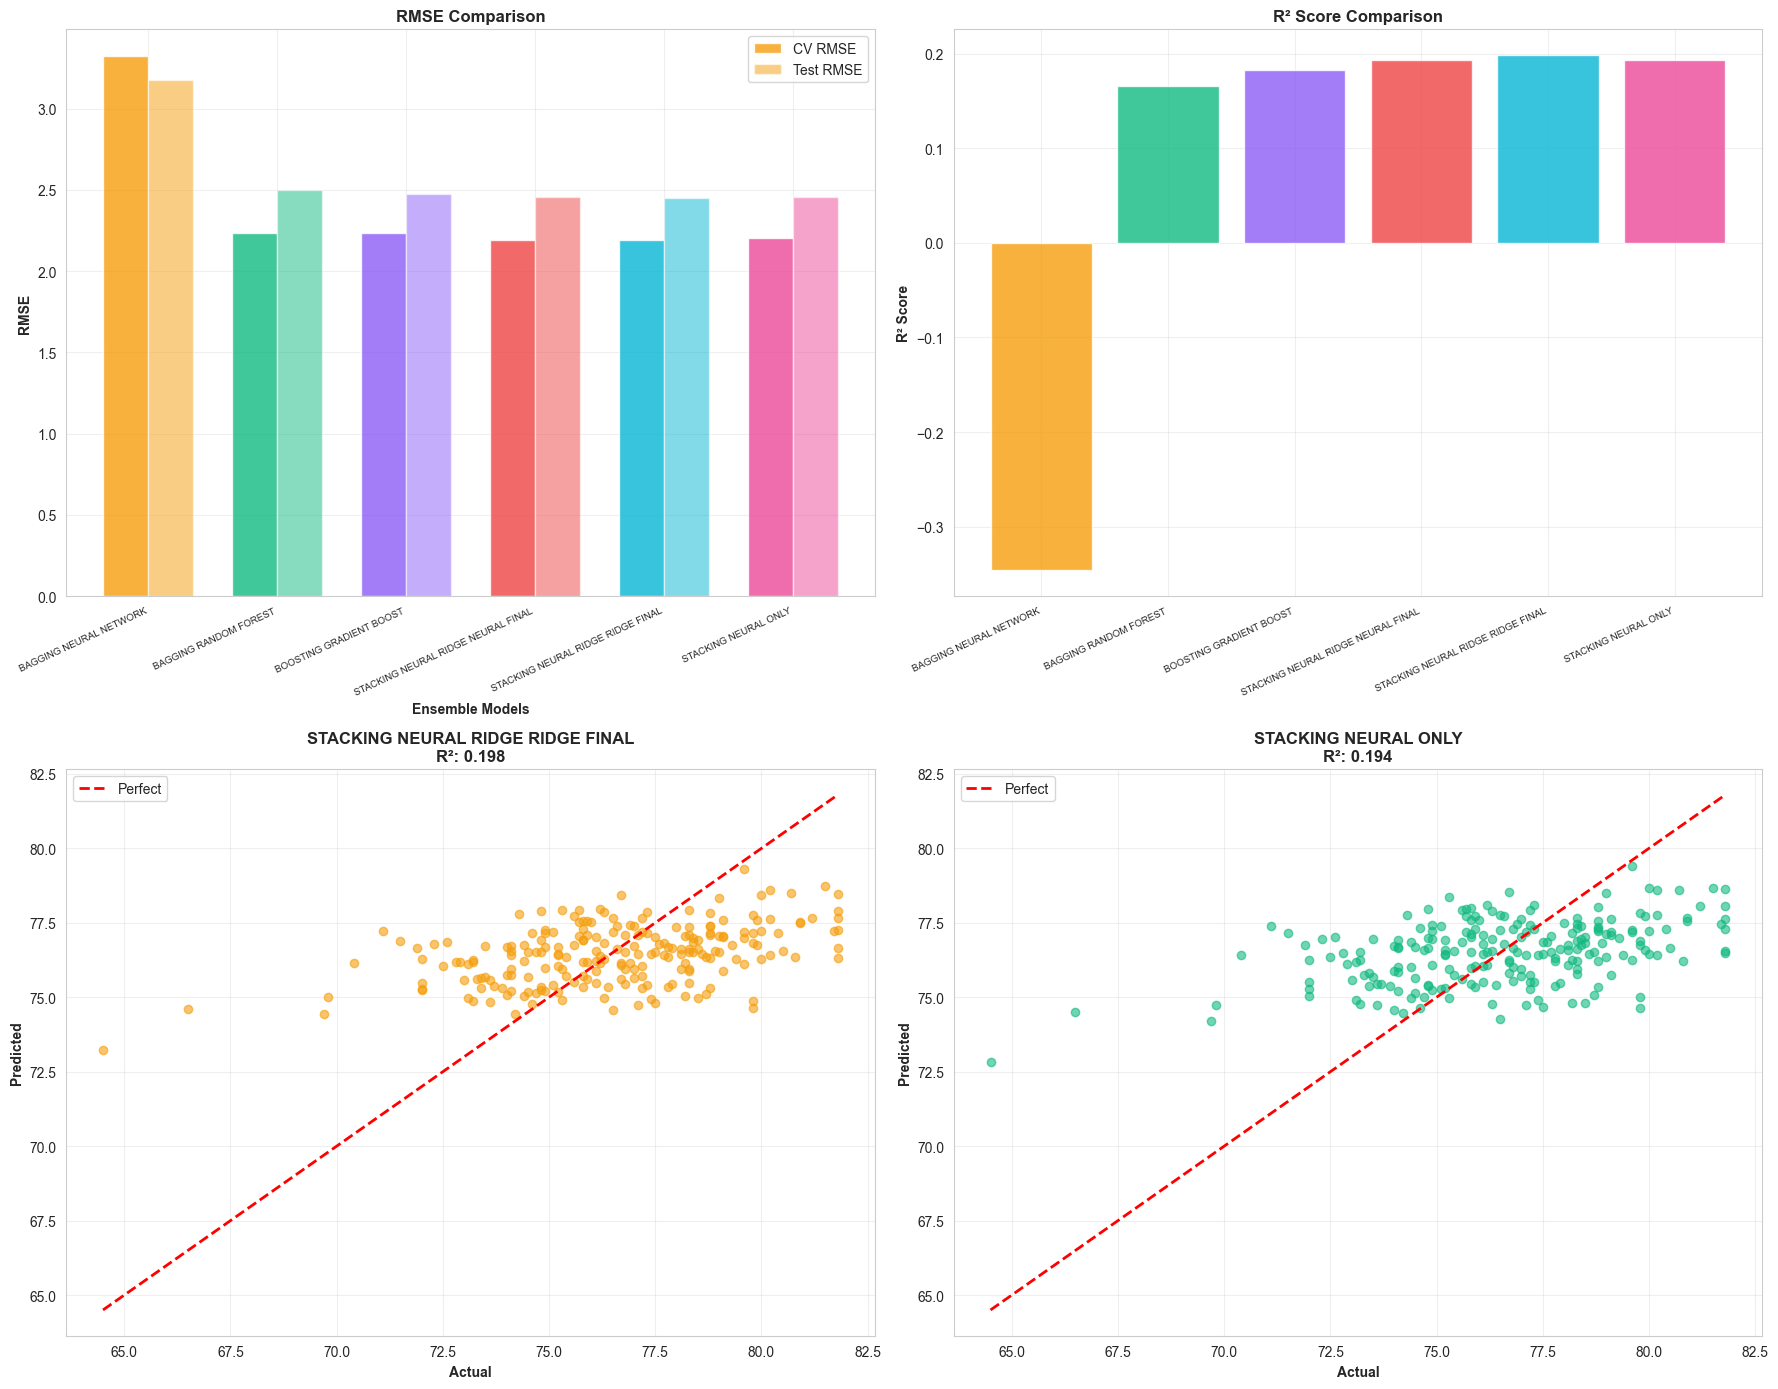


SAVING ENSEMBLE MODELS
   [OK] bagging_neural_network_ensemble.pkl saved and verified (Size: 1816821 bytes)
   [OK] bagging_random_forest_ensemble.pkl saved and verified (Size: 1950660 bytes)
   [OK] boosting_gradient_boost_ensemble.pkl saved and verified (Size: 133234 bytes)
   [OK] stacking_neural_ridge_neural_final_ensemble.pkl saved and verified (Size: 259091 bytes)
   [OK] stacking_neural_ridge_ridge_final_ensemble.pkl saved and verified (Size: 122258 bytes)
   [OK] stacking_neural_only_ensemble.pkl saved and verified (Size: 133954 bytes)

All ensemble models saved to: models/saved_ensemble_models/

ENSEMBLE vs BASE MODELS COMPARISON

    Type                              Model     RMSE      MAE
Ensemble  STACKING NEURAL RIDGE RIDGE FINAL 2.451288 1.980781
    Base                              RIDGE 2.456365 1.987608
Ensemble               STACKING NEURAL ONLY 2.458440 1.994808
Ensemble STACKING NEURAL RIDGE NEURAL FINAL 2.458513 1.992685
    Base                     NEURAL_NETWO

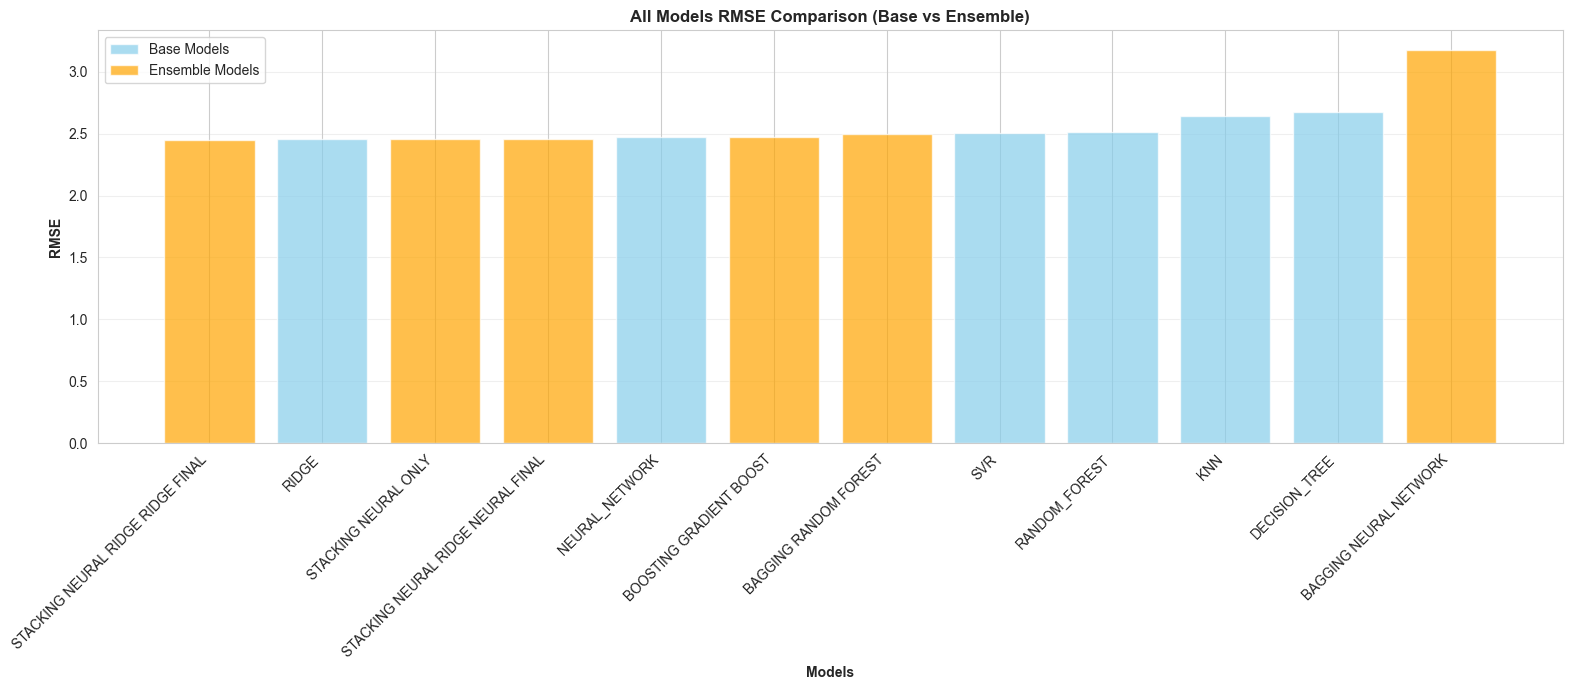


Best Overall Model: STACKING NEURAL RIDGE RIDGE FINAL
   Type: Ensemble
   RMSE: 2.4513
   MAE: 1.9808

STACKING FINAL ESTIMATOR COMPARISON

                             Model Final Estimator  Test RMSE  CV RMSE  Test R²
 STACKING NEURAL RIDGE RIDGE FINAL           Ridge   2.451288 2.190410 0.198385
              STACKING NEURAL ONLY  Neural Network   2.458440 2.205021 0.193700
STACKING NEURAL RIDGE NEURAL FINAL  Neural Network   2.458513 2.193464 0.193653

Analysis:
Ridge as final estimator generally provides more stable predictions
Neural Network as final estimator can capture complex patterns but may overfit
Choose Ridge for better generalization, Neural Network for complex data patterns

SAVING ENSEMBLE MODEL METADATA
   Saved metadata: ../regression_processed_data/bagging_neural_network_metadata.json
   Saved metadata: ../regression_processed_data/bagging_random_forest_metadata.json
   Saved metadata: ../regression_processed_data/boosting_gradient_boost_metadata.json
   Saved met

In [4]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import json
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("All libraries imported successfully")

# Cell 2: Load Data and Base Models
X_train = np.load('../regression_processed_data/X_train.npy')
X_test = np.load('../regression_processed_data/X_test.npy')
y_train = np.load('../regression_processed_data/y_train.npy')
y_test = np.load('../regression_processed_data/y_test.npy')

# Load feature names for feature importance analysis
with open('../regression_processed_data/feature_names.json', 'r') as f:
    feature_names = json.load(f)

# Load base models
base_models = {}
for model_name in ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge', 'neural_network']:
    base_models[model_name] = joblib.load(f'../saved_base_models/{model_name}_model.pkl')

print(f"Data Loaded:")
print(f"   Training: {X_train.shape}, Test: {X_test.shape}")
print(f"   Features: {len(feature_names)}")
print(f"Base models loaded: {list(base_models.keys())}")

# Cell 3: Create Ensemble Models
# Neural network for bagging base estimator
neural_bagging_base = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    alpha=0.001,
    learning_rate='adaptive',
    random_state=42,
    max_iter=1000,
    early_stopping=True,
    validation_fraction=0.1
)

# Neural network for final estimator in stacking
neural_final_estimator = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    alpha=0.001,
    learning_rate='adaptive',
    random_state=42,
    max_iter=1000,
    early_stopping=True
)

# Ridge regression for final estimator in stacking
ridge_final_estimator = Ridge(
    alpha=1.0,
    random_state=42
)

ensemble_models = {
    'bagging_neural_network': BaggingRegressor(
        estimator=neural_bagging_base,
        n_estimators=10,
        max_samples=0.8,
        max_features=0.8,
        random_state=42,
        n_jobs=-1
    ),
    'bagging_random_forest': RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        bootstrap=True
    ),
    'boosting_gradient_boost': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
    'stacking_neural_ridge_neural_final': StackingRegressor(
        estimators=[
            ('neural_network', base_models['neural_network']),
            ('ridge', base_models['ridge'])
        ],
        final_estimator=neural_final_estimator,
        cv=5,
        n_jobs=-1
    ),
    'stacking_neural_ridge_ridge_final': StackingRegressor(
        estimators=[
            ('neural_network', base_models['neural_network']),
            ('ridge', base_models['ridge'])
        ],
        final_estimator=ridge_final_estimator,
        cv=5,
        n_jobs=-1
    ),
    'stacking_neural_only': StackingRegressor(
        estimators=[
            ('neural_network_1', base_models['neural_network'])
        ],
        final_estimator=MLPRegressor(
            hidden_layer_sizes=(50,),
            activation='relu',
            alpha=0.001,
            learning_rate='adaptive',
            random_state=42,
            max_iter=1000,
            early_stopping=True
        ),
        cv=5,
        n_jobs=-1
    )
}

print("Ensemble Models Created:")
for name in ensemble_models.keys():
    print(f"   {name.replace('_', ' ').upper()}")

print("\nNOTE: Bagging applied to Neural Network with 10 estimators")
print("NOTE: Stacking with Neural Network final estimator")
print("NOTE: Stacking with Ridge final estimator")
print("NOTE: Neural-only stacking configuration")

# Cell 4: Train Ensemble Models with 10-Fold CV
cv = KFold(n_splits=10, shuffle=True, random_state=42)
ensemble_results = {}

print("\n" + "=" * 70)
print("TRAINING ENSEMBLE MODELS WITH 10-FOLD CROSS-VALIDATION")
print("=" * 70)

for name, model in ensemble_models.items():
    print(f"\n[MODEL] Training {name.upper()} with 10-fold CV...")
    
    # Perform 10-fold CV
    fold_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
    
    cv_mse_scores = -fold_scores
    cv_mean = np.mean(cv_mse_scores)
    cv_std = np.std(cv_mse_scores)
    cv_rmse = np.sqrt(cv_mean)
    
    # Train on full training set
    model.fit(X_train, y_train)
    
    # Test predictions
    y_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)
    
    ensemble_results[name] = {
        'model': model,
        'cv_mse_mean': cv_mean,
        'cv_mse_std': cv_std,
        'cv_rmse': cv_rmse,
        'cv_10fold_scores': fold_scores.tolist(),
        'test_mse': test_mse,
        'test_rmse': test_rmse,
        'test_mae': test_mae,
        'test_r2': test_r2,
        'y_pred': y_pred
    }
    
    print(f"   {name.replace('_', ' ').upper()} Trained")
    print(f"      10-Fold CV RMSE: {cv_rmse:.4f}")
    print(f"      Test RMSE: {test_rmse:.4f}")
    print(f"      Test R²: {test_r2:.4f}")

# Cell 5: Compare Ensemble Models
summary_data = []
for name, data in ensemble_results.items():
    summary_data.append({
        'Model': name.replace('_', ' ').upper(),
        'CV RMSE': f"{data['cv_rmse']:.4f}",
        'Test RMSE': f"{data['test_rmse']:.4f}",
        'Test MAE': f"{data['test_mae']:.4f}",
        'Test R²': f"{data['test_r2']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("ENSEMBLE MODEL PERFORMANCE SUMMARY")
print("=" * 70)
print(summary_df.to_string(index=False))

print("\n" + "=" * 70)
print("DETAILED ENSEMBLE TEST RESULTS")
print("=" * 70)

sorted_models = sorted(ensemble_results.items(), key=lambda x: x[1]['test_rmse'])

print(f"\n{'Rank':<5} {'Model':<50} {'Test RMSE':<12} {'CV RMSE':<12} {'R²':<10}")
print("-" * 90)

for rank, (name, data) in enumerate(sorted_models, 1):
    print(f"{rank:<5} {name.replace('_', ' ').upper():<50} "
          f"{data['test_rmse']:<12.4f} {data['cv_rmse']:<12.4f} {data['test_r2']:<10.4f}")

best_model = sorted_models[0]
print(f"\nBest Ensemble Model: {best_model[0].replace('_', ' ').upper()}")
print(f"   Test RMSE: {best_model[1]['test_rmse']:.4f}")
print(f"   Test R²: {best_model[1]['test_r2']:.4f}")
print(f"   10-Fold CV RMSE: {best_model[1]['cv_rmse']:.4f}")

# Cell 5.5: Detailed Ensemble Predictions Analysis
print("\n" + "=" * 70)
print("ENSEMBLE TEST PREDICTIONS ANALYSIS")
print("=" * 70)

os.makedirs('../saved_ensemble_models', exist_ok=True)

for name, data in ensemble_results.items():
    y_pred = data['y_pred']
    
    prediction_details = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Error': y_test - y_pred,
        'Absolute_Error': np.abs(y_test - y_pred),
        'Percent_Error': np.abs((y_test - y_pred) / y_test) * 100
    })
    
    print(f"\n{name.replace('_', ' ').upper()}")
    print(f"   Total Test Samples: {len(y_test)}")
    print(f"   Test RMSE: {data['test_rmse']:.4f}")
    print(f"   Test MAE:  {data['test_mae']:.4f}")
    print(f"   Test R²:   {data['test_r2']:.4f}")
    print(f"   10-Fold CV RMSE: {data['cv_rmse']:.4f}")
    
    residuals = y_test - y_pred
    print(f"   Mean Residual: {np.mean(residuals):.4f}")
    print(f"   Std Residual:  {np.std(residuals):.4f}")
    
    print(f"\n   Error Statistics:")
    print(f"   Mean Absolute Error: {prediction_details['Absolute_Error'].mean():.4f}")
    print(f"   Median Absolute Error: {prediction_details['Absolute_Error'].median():.4f}")
    print(f"   Max Error: {prediction_details['Absolute_Error'].max():.4f}")
    print(f"   Min Error: {prediction_details['Absolute_Error'].min():.4f}")
    
    print(f"\n   First 10 predictions:")
    print(prediction_details.head(10).to_string(index=False))
    
    large_errors = prediction_details[prediction_details['Absolute_Error'] > data['test_rmse']]
    if len(large_errors) > 0:
        print(f"\n   Samples with error > RMSE ({len(large_errors)} samples):")
        print(large_errors.head(5).to_string(index=False))
    
    csv_file = f'../saved_ensemble_models/{name}_test_predictions.csv'
    prediction_details.to_csv(csv_file, index=False)
    print(f"\n   Saved detailed predictions: {csv_file}")

# Cell 6: Feature Importance Analysis for Ensemble Models
print("\n" + "=" * 70)
print("ENSEMBLE FEATURE IMPORTANCE ANALYSIS")
print("=" * 70)

ensemble_feature_importance = {}

for name, data in ensemble_results.items():
    model = data['model']
    
    print(f"\n{name.replace('_', ' ').upper()}:")
    
    # Check if model has native feature importance
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importance
        }).sort_values('Importance', ascending=False)
        
        ensemble_feature_importance[name] = {
            'method': 'native',
            'importance': feature_importance_df.to_dict('records')
        }
        
        print(f"   Method: Native Feature Importance")
        print(f"   Top 10 Features:")
        print(feature_importance_df.head(10).to_string(index=False))
        
    else:
        # Use permutation importance for models without native feature importance
        print(f"   Calculating permutation importance...")
        
        perm_importance = permutation_importance(
            model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1
        )
        
        feature_importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': perm_importance.importances_mean,
            'Std': perm_importance.importances_std
        }).sort_values('Importance', ascending=False)
        
        ensemble_feature_importance[name] = {
            'method': 'permutation',
            'importance': feature_importance_df.to_dict('records')
        }
        
        print(f"   Method: Permutation Importance")
        print(f"   Top 10 Features:")
        print(feature_importance_df[['Feature', 'Importance', 'Std']].head(10).to_string(index=False))

# Save feature importance to JSON
print("\n" + "=" * 70)
print("SAVING FEATURE IMPORTANCE TO JSON")
print("=" * 70)

for name, importance_data in ensemble_feature_importance.items():
    json_file = f'../saved_ensemble_models/{name}_feature_importance.json'
    
    with open(json_file, 'w') as f:
        json.dump(importance_data, f, indent=2)
    
    print(f"   Saved: {name}_feature_importance.json")

print("\nAll feature importance files saved to: models/saved_ensemble_models/")

# Cell 6.5: Visualize Ensemble Feature Importance
num_models = len(ensemble_feature_importance)
rows = (num_models + 1) // 2
fig, axes = plt.subplots(rows, 2, figsize=(20, 6 * rows))
axes = axes.flatten()

colors_importance = ['#f59e0b', '#10b981', '#8b5cf6', '#ef4444', '#06b6d4', '#ec4899']

for idx, (name, importance_data) in enumerate(ensemble_feature_importance.items()):
    if idx >= len(axes):
        break
    
    # Get top 10 features
    top_10 = importance_data['importance'][:10]
    features = [item['Feature'] for item in top_10]
    importances = [item['Importance'] for item in top_10]
    
    axes[idx].barh(features, importances, color=colors_importance[idx % len(colors_importance)], 
                   alpha=0.8, edgecolor='black')
    axes[idx].set_xlabel('Importance', fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Features', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{name.replace("_", " ").upper()}\n({importance_data["method"].capitalize()} Importance)',
                       fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

# Hide unused subplots
for idx in range(num_models, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

# Cell 7: Visualize Ensemble Performance
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

model_names = list(ensemble_results.keys())
colors = ['#f59e0b', '#10b981', '#8b5cf6', '#ef4444', '#06b6d4', '#ec4899']

# Plot 1: RMSE Comparison
x = np.arange(len(model_names))
width = 0.35

cv_rmse = [ensemble_results[name]['cv_rmse'] for name in model_names]
test_rmse = [ensemble_results[name]['test_rmse'] for name in model_names]

axes[0, 0].bar(x - width/2, cv_rmse, width, label='CV RMSE', 
               color=colors[:len(model_names)], alpha=0.8)
axes[0, 0].bar(x + width/2, test_rmse, width, label='Test RMSE', 
               color=colors[:len(model_names)], alpha=0.5)
axes[0, 0].set_xlabel('Ensemble Models', fontweight='bold')
axes[0, 0].set_ylabel('RMSE', fontweight='bold')
axes[0, 0].set_title('RMSE Comparison', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels([n.replace('_', ' ').upper() for n in model_names], 
                           rotation=25, ha='right', fontsize=7)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: R² Score Comparison
r2_scores = [ensemble_results[name]['test_r2'] for name in model_names]
axes[0, 1].bar([n.replace('_', ' ').upper() for n in model_names], r2_scores, 
               color=colors[:len(model_names)], alpha=0.8)
axes[0, 1].set_ylabel('R² Score', fontweight='bold')
axes[0, 1].set_title('R² Score Comparison', fontweight='bold')
axes[0, 1].set_xticklabels([n.replace('_', ' ').upper() for n in model_names], 
                           rotation=25, ha='right', fontsize=7)
axes[0, 1].grid(alpha=0.3)

# Plot 3 & 4: Prediction vs Actual for top 2 models
sorted_models = sorted(model_names, key=lambda x: ensemble_results[x]['test_r2'], reverse=True)
for idx, name in enumerate(sorted_models[:2]):
    y_pred = ensemble_results[name]['y_pred']
    
    axes[1, idx].scatter(y_test, y_pred, alpha=0.6, color=colors[idx])
    
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    axes[1, idx].plot([min_val, max_val], [min_val, max_val], 
                      'r--', linewidth=2, label='Perfect')
    
    axes[1, idx].set_xlabel('Actual', fontweight='bold')
    axes[1, idx].set_ylabel('Predicted', fontweight='bold')
    axes[1, idx].set_title(f'{name.replace("_", " ").upper()}\nR²: {ensemble_results[name]["test_r2"]:.3f}',
                          fontweight='bold')
    axes[1, idx].legend()
    axes[1, idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Cell 8: Save Ensemble Models with Validation
import pickle

os.makedirs('../saved_ensemble_models', exist_ok=True)

print("\n" + "=" * 70)
print("SAVING ENSEMBLE MODELS")
print("=" * 70)

for name, data in ensemble_results.items():
    model_file = f'../saved_ensemble_models/{name}_ensemble.pkl'
    
    try:
        with open(model_file, 'wb') as f:
            pickle.dump(data['model'], f, protocol=pickle.HIGHEST_PROTOCOL)
        
        with open(model_file, 'rb') as f:
            loaded_model = pickle.load(f)
        
        file_size = os.path.getsize(model_file)
        print(f"   [OK] {name}_ensemble.pkl saved and verified (Size: {file_size} bytes)")
        
    except Exception as e:
        print(f"   [ERROR] Failed to save {name}_ensemble.pkl: {str(e)}")

print("\nAll ensemble models saved to: models/saved_ensemble_models/")

# Cell 9: Compare Ensemble vs Base Models
print("\n" + "=" * 70)
print("ENSEMBLE vs BASE MODELS COMPARISON")
print("=" * 70)

base_model_results = {}
for model_name in ['knn', 'decision_tree', 'random_forest', 'svr', 'ridge', 'neural_network']:
    try:
        predictions = pd.read_csv(f'../saved_base_models/{model_name}_test_predictions.csv')
        base_model_results[model_name] = {
            'mae': predictions['Absolute_Error'].mean(),
            'rmse': np.sqrt(np.mean(predictions['Error']**2))
        }
    except:
        pass

all_results = []
for name, metrics in base_model_results.items():
    all_results.append({
        'Type': 'Base',
        'Model': name.upper(),
        'RMSE': metrics['rmse'],
        'MAE': metrics['mae']
    })

for name, data in ensemble_results.items():
    all_results.append({
        'Type': 'Ensemble',
        'Model': name.replace('_', ' ').upper(),
        'RMSE': data['test_rmse'],
        'MAE': data['test_mae']
    })

comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.sort_values('RMSE')

print("\n" + comparison_df.to_string(index=False))

fig, ax = plt.subplots(figsize=(16, 7))

x = np.arange(len(comparison_df))
colors_bar = ['skyblue' if t == 'Base' else 'orange' for t in comparison_df['Type']]
bars = ax.bar(x, comparison_df['RMSE'], color=colors_bar, alpha=0.7)

ax.set_xlabel('Models', fontweight='bold')
ax.set_ylabel('RMSE', fontweight='bold')
ax.set_title('All Models RMSE Comparison (Base vs Ensemble)', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='skyblue', alpha=0.7, label='Base Models'),
                   Patch(facecolor='orange', alpha=0.7, label='Ensemble Models')]
ax.legend(handles=legend_elements)

plt.tight_layout()
plt.show()

best_overall = comparison_df.iloc[0]
print(f"\nBest Overall Model: {best_overall['Model']}")
print(f"   Type: {best_overall['Type']}")
print(f"   RMSE: {best_overall['RMSE']:.4f}")
print(f"   MAE: {best_overall['MAE']:.4f}")

# Cell 10: Compare Stacking Final Estimators
print("\n" + "=" * 70)
print("STACKING FINAL ESTIMATOR COMPARISON")
print("=" * 70)

stacking_models = {k: v for k, v in ensemble_results.items() if 'stacking' in k}

stacking_comparison = []
for name, data in stacking_models.items():
    final_estimator_type = 'Neural Network' if 'neural_final' in name or 'neural_only' in name else 'Ridge'
    stacking_comparison.append({
        'Model': name.replace('_', ' ').upper(),
        'Final Estimator': final_estimator_type,
        'Test RMSE': data['test_rmse'],
        'CV RMSE': data['cv_rmse'],
        'Test R²': data['test_r2']
    })

stacking_df = pd.DataFrame(stacking_comparison)
stacking_df = stacking_df.sort_values('Test RMSE')

print("\n" + stacking_df.to_string(index=False))

print("\nAnalysis:")
print("Ridge as final estimator generally provides more stable predictions")
print("Neural Network as final estimator can capture complex patterns but may overfit")
print("Choose Ridge for better generalization, Neural Network for complex data patterns")

# Cell 11: Save Ensemble Model Metadata for Database Import
print("\n" + "=" * 70)
print("SAVING ENSEMBLE MODEL METADATA")
print("=" * 70)

for name, data in ensemble_results.items():
    metadata = {
        'model_name': name,
        'model_type': 'ensemble_regression',
        'cv_rmse': float(data['cv_rmse']),
        'cv_std': float(data['cv_mse_std']),
        'cv_mean': float(data['cv_mse_mean']),
        'test_rmse': float(data['test_rmse']),
        'test_mae': float(data['test_mae']),
        'test_r2': float(data['test_r2']),
        'test_mse': float(data['test_mse']),
        'cv_10fold_scores': data['cv_10fold_scores'],
        'trained_at': pd.Timestamp.now().isoformat()
    }
    
    metadata_file = f'../regression_processed_data/{name}_metadata.json'
    with open(metadata_file, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"   Saved metadata: {metadata_file}")

print("\nMetadata files saved to: models/regression_processed_data/")
print("\n" + "=" * 70)
print("ENSEMBLE MODELS TRAINING COMPLETE")
print("=" * 70)

print(" Feature importance calculated and saved to JSON for all models")
